# Exploratory Data Analysis for Example data of gait abnormality.

This EDA is going to look at example data taken by myself as a means of experimenting with novel GCN architectures and for ascertaining the qualities these novel architectures should have in order to extract the data we want to make the medical inferences we need to.

The data is split in 3 categories, with 10 sequences each, with each sequence being 88-157 frames each, 480 x 480 resolution all of the same individual (me) in the same environment but sometimes wearing slightly different clothing. The main difference between the three categories is my gait.

Set 1: My gait is normal, I walk past the camera 5 times in each direction to produce 10 sequences of my normal healthy gait.

Set 2: My gait is marginally impaired. I achieved this by simulating a slight limp.

Set 3: My gait is severely impaired. I acheived this by shuffling my feet, not moving my arms, keeping my head down in an effort to mimic the effect of advanced dementia on standard gait.

The goal of this EDA is to identify the key differences in the data between these sets and work out how to make them as differentiable as possible. The plan thus far is to process all of the images into skeletal graphs via Higher HRNet, load them in here and chart out each of the 17 variables across sequences (so 3 separate coloured dots) to see how different each one is. 

Then I want to create a normal distribution of each of the 3 by decimating the 17 joints in each frame to 3D co-ordinates to view and see if there is clean cut normal distributions.

There are two eventualities when I process this data: either they are extremely separable or they aren't. 

If they are separable, then there is no major problems and I can implement a GCN in here and see how accurate it is. 

If it isn't separable, then I need to work with the data, find the most definining joints and redundant ones, etc. 

compare different GCN's with the data, see if there is major differences, play with different modules potentially invent a new one to improve the performance on the standard ones.

In [51]:
##SKLEARN
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#TSNE exploration
from sklearn.manifold import TSNE
#PCA
from sklearn.decomposition import PCA
##ML models and feature selection
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

##Matplotlib
import matplotlib.pyplot as plt
# unused but required import for doing 3d projections with matplotlib < 3.2
from mpl_toolkits import mplot3d
import seaborn as sns
#OpenCV
import cv2

#Utility functions for dataset management
import ast
import copy
import pandas as pd
import os
import numpy as np

#Load in the dataset
colnames=['Instance', 'No_In_Sequence', 'Class', 'Joint_1','Joint_2','Joint_3','Joint_4','Joint_5','Joint_6','Joint_7',
          'Joint_8','Joint_9','Joint_10','Joint_11','Joint_12','Joint_13','Joint_14','Joint_15','Joint_16', 'Joint_17'] 
dataset_master = pd.read_csv("velocity_emptyframes.csv", names=colnames, header=None)

#Dataset is currently 2 instances worth of severe gait obstruction (simulated parkinson's).
dataset_master.head()

,Instance,No_In_Sequence,Class,Joint_1,Joint_2,Joint_3,Joint_4,Joint_5,Joint_6,Joint_7,Joint_8,Joint_9,Joint_10,Joint_11,Joint_12,Joint_13,Joint_14,Joint_15,Joint_16,Joint_17
0,2,3,0,"[0.426268560116704, 0.1105140711413677, 0.2368...","[0.426268560116704, 0.1105140711413677, 0.2368...","[0.42469148825012076, 0.09800572805772018, 0.2...","[0.4008918628686366, 0.1336306209562122, 0.267...","[0.4334588768708565, 0.06421612990679355, 0.24...","[0.4616330542123694, 0.06074119134373282, 0.18...","[0.4597781241093491, 0.062132178933695825, 0.1...","[0.16603282261510266, 0.044102468507136644, 0....","[0.1690619028153408, 0.04098470371280989, 0.46...","[0.2379454078380647, 0.055520595162215094, 0.4...","[0.2358926025126595, 0.05566005227826797, 0.43...","[0.20102574675913196, 0.018461548171757016, 0....","[0.4928749802465649, 0.03556829754356654, 0.07...","[0.2638650952275984, 0.02700981289731322, 0.42...","[0.27449340129713784, -0.022316536690824215, 0...","[0.2488249330582115, 0.05443045410648376, 0.43...","[0.250076212120883, 0.05791238596483606, 0.429..."
1,2,4,0,"[0.31746281824712064, 0.24770391958562366, 0.7...","[0.30641598031978035, 0.26263465319130885, 0.6...","[0.06427495579919196, 0.4445600861836123, 0.24...","[0.09673287425358623, 0.5279107913831282, 0.22...","[-0.0036197611899115856, 0.30703759549610976, ...","[0.3914162867593305, 0.21356592050623524, 0.65...","[-0.03636081424748383, 0.12414954622829999, 0....","[0.07255702971104938, 0.2905386497996343, 0.04...","[0.17796245185770232, 0.002415657862595566, -0...","[0.2671308281089537, 0.4495237688192173, 0.129...","[0.29756242267139044, 0.10851989812861085, -0....","[0.19092885657675396, 0.19010868127207914, -0....","[0.502734976274958, 0.07993827967134148, 0.574...","[0.4079423413390231, 0.26713855641635487, 0.00...","[0.35395168833471047, 0.051466158415497176, -0...","[0.6458504435608887, 0.22118116851760838, 0.17...","[0.7249747092921268, -0.07070595701904203, 0.5..."
2,2,5,0,"[-0.11657755395291991, 0.6268140096945132, 0.3...","[-0.11985257979692343, 0.6472488714689604, 0.3...","[-0.360416532450928, 0.8465543581258927, 0.0]","[-0.3041589886150497, 0.8933064596683629, -0.0...","[-0.4279892312270114, 0.5427718911033121, 0.39...","[-0.03595733196166506, 0.6324568260417749, 0.3...","[-0.5012881078370288, 0.3297741802647489, 0.42...","[-0.0113587966730897, 0.7391381586782586, -0.4...","[-0.03994904962666368, 0.18396801475312663, -0...","[0.029185420270891882, 0.88517245686824, -0.21...","[0.27286528466750326, 0.4752507748678809, -0.6...","[0.0184292946099589, 0.6470835463059252, -0.62...","[0.018300693218264996, 0.5339304191400034, 0.3...","[0.12754775598874346, 0.6533659965860927, -0.6...","[0.10331519303090886, 0.39585092601618843, -0....","[0.5109860869623049, 0.3376915791005821, -0.70...","[0.5385854385132518, 0.31344395574308015, -0.1..."
3,2,6,0,"[0.07687808511412753, 0.969306912035897, -0.21...","[0.0, 0.9370222475925445, -0.3035712759090643]","[0.0, 1.0, 0.0]","[0.018020049448685314, 0.5831198533353046, 0.5...","[-0.02574724388082339, 0.7528268848035466, 0.1...","[0.09700501600519296, 0.9502239507328909, -0.2...","[0.07656103712523255, 0.7580180526027043, 0.36...","[0.22013010809942912, 0.9412445909582914, -0.1...","[0.07185153872729089, 0.7053416101886079, 0.39...","[0.08318903308077097, 0.7199391241833553, -0.3...","[0.38144677066051713, 0.8905820209348505, -0.2...","[0.14783618204671, 0.952676402223112, -0.24162...","[0.09475599783713307, 0.9786804740134016, -0.1...","[0.04444158596228931, 0.9010058617468033, -0.3...","[0.1503480124000589, 0.7964098799351262, 0.476...","[0.038150772101744224, 0.20884576686840006, 0....","[0.34213199080352297, 0.839840940814824, -0.34..."
4,2,7,0,"[0.026526077825555383, 0.9446733057609151, -0....","[0.0, 0.9375079085148457, -0.3000257202550216]","[0.0, 1.0, 0.0]","[0.0005569256171653603, 0.153946059419944, -0....","[-0.040791986435549044, 0.5600725022669764, -0...","[0.0008471344547995585, 0.9657794223257596, -0...","[0.02358638723

In [52]:
################DATASET MAINTENANCE FUNCTIONS #############################
###########################################################################
#Fix Class labels to be correct and either 0, 1, or 2 for normal, limp and stagger.
def fix_class_labels(data, save = False):
    class_label = 0
    instances_iterated = 1
    current_frame = 0
    last_frame = 0
    instance_iter_check = False
    
    for index, row in data.iterrows():
        cols_empty = 0
        
        #After every 5 instances, switch to the next class then back to 0 after getting to 2.
        if instances_iterated % 5 == 0 and instance_iter_check == False:
            class_label += 1
            if class_label > 2:
                class_label = 0
            instance_iter_check = True
            
            print("5 instances completed, new class being assigned is: ", class_label)
        #Assign the new class to the row
        data.iat[index, 2] = class_label
        
        #Check if a new sequence has started, if this is the case it means an instance is done iterating.
        last_frame = current_frame
        current_frame = row[1]
        
        if current_frame < last_frame:
            print("new instance number: ", index, " : ", current_frame, last_frame)
            instances_iterated += 1
            instance_iter_check = False

        if save:
            data.to_csv("gait_pixel_dataset_occluded.csv",index=False, header=False)      
    
    return data

#Remove all frames where most or all joints are missing
def remove_empty_frames(data, save = False):
    #Next step: remove all blank frames (Frames with no joints present)
    print("Files before deletion: ", len(data))
    deletion_indices = []

    for index, row in data.iterrows():
        cols_empty = 0
        for col_index, col in enumerate(row):
            if col_index >= 3:
                #Cast all data to numerical values
                tmp = ast.literal_eval(row[col_index])

                if all(v == 0 for v in tmp):
                    cols_empty +=1

                data.iat[index, col_index] = tmp
        

        if cols_empty > 5:
            deletion_indices.append(index)

    data.drop(deletion_indices, inplace=True)
    print("Files after empty frames deleted: ", len(data))
    
    if save:
        data.to_csv("velocity_emptyframes.csv",index=False, header=False)
        
    return data

#Split data into the three classes
def split_by_class(data):
    regular = []
    limp = []
    stagger = []
    for index, row in data.iterrows():
        if data.iat[index, 2] == 0:
            regular.append(copy.deepcopy(row))
        if data.iat[index, 2] == 1:
            limp.append(copy.deepcopy(row))
        if data.iat[index, 2] == 2:
            stagger.append(copy.deepcopy(row))

    return pd.DataFrame(regular), pd.DataFrame(limp), pd.DataFrame(stagger)
            
    
#Split classes into instances, work out how to know where one ends and next begins (using sequencing)
def split_class_by_instance(data):
    filtered_data = []
    instance = []
    current_frame = 0
    last_frame = 0
    print("length of data: ", len(data))
    for i, (index, row) in enumerate(data.iterrows()):
        #print("index: ", index, i)
        last_frame = current_frame
        current_frame = data.iat[i, 1]
        
        if current_frame < last_frame:
            filtered_data.append(copy.deepcopy(instance))
            instance = []

        instance.append(row)
            
    filtered_frame = pd.DataFrame(filtered_data)
    return filtered_frame

def convert_to_literals(data):

    #Convert all strings in reloaded array back to numbers
    for i,  (index, row) in enumerate(data.iterrows()):
        for col_index, col in enumerate(row):
            if col_index >= 3:
                tmp = ast.literal_eval(row[col_index])
                data.iat[i, col_index] = copy.deepcopy(tmp)
            else:
                data.iat[i, col_index] = int(data.iat[i, col_index])
                
#All joint mini-dataframes will have instance, no-in-sequence and class designation
def separate_coordinate_arrays(data):
    
    #Separate into mini dataframes for each joint
    joint_dataframes = []

    for i in range(data.shape[1]):
        if i >= 3:
            joint_only_frame = data.iloc[:, :3]
            joint_only_frame['Class'] = joint_only_frame['Class'].astype(float)
            #Take the joint column for this array
            tmp = data.iloc[:, i]

            separated_coords = pd.DataFrame(columns = ['x_coord', 'y_coord', 'z_coord'])
            for j in range(3):
                #For every coordinate create a new array
                new_column = []
                #Populate this empty array
                for k in range(tmp.shape[0]):
                    new_column.append(tmp.iloc[k][j])

                #Convert it to a series and add it to the array of them
                if j == 0:
                    separated_coords['x_coord'] = (pd.Series(copy.deepcopy(new_column)))
                elif j == 1:
                    separated_coords['y_coord'] = (pd.Series(copy.deepcopy(new_column)))
                elif j == 2:
                    separated_coords['z_coord'] = (pd.Series(copy.deepcopy(new_column)))

            #add the dataframe with the individual co-ordinates to the template with the class data
            joint_only_frame = joint_only_frame.merge(separated_coords, left_index = True, right_index = True)
            #add this to the array containing the same dataframes for every individual joint in the master array
            joint_dataframes.append(copy.deepcopy(joint_only_frame))


    #Check there are 17: one for each joint and that each co-ordinate has its own column    
    print(len(joint_dataframes))       
    joint_dataframes[3].head()
    return copy.deepcopy(joint_dataframes)

#Function to unravel all joints into one long feature vector
def unravel_joint_coords(data, save = False, get_relative = False, origin_point = 3):
    new_col_names = ['']
    new_dataframe = []
    for i, (index, row) in enumerate(data.iterrows()):
        new_row = [row[0], row[1], row[2]]
        #3 is nose origin, 4 is chest origin (nose by default)
        origin = row[origin_point]
        #Everything at index 3 and onwards needs unravelled
        for j, value in enumerate(row):
            if j >= 3:
                #Get relative values
                if get_relative == True:
                    #3 is head, 4 is chest
                    #Head origin
                    if origin_point == 3:
                        if j >= 4:
                            for ik, k in enumerate(value):
                                new_row.append(abs(origin[ik]-k))
                        else:
                            for k in value:
                                new_row.append(k)
                    else:
                        #Chest origin
                        if j >= 3 and j != 4:
                            for ik, k in enumerate(value):
                                new_row.append(abs(origin[ik]-k))
                        else:
                            for k in value:
                                new_row.append(k)
                        
                else:
                    #Unroll and add individual co-ordinates to new row
                    for k in value:
                        new_row.append(k)
        #New total row length should be 17 * 3 = 51 + 3 first features = 54 feature length vector.
        #add new row to new array
        new_dataframe.append(new_row)
    
    #Add column names and convert to dataframe
    colnames=['Instance', 'No_In_Sequence', 'Class', \
              'Joint_1_x', 'Joint_1_y', 'Joint_1_z',\
              'Joint_2_x','Joint_2_y','Joint_2_z',\
              'Joint_3_x','Joint_3_y','Joint_3_z',\
              'Joint_4_x','Joint_4_y','Joint_4_z',\
              'Joint_5_x','Joint_5_y','Joint_5_z',\
              'Joint_6_x','Joint_6_y','Joint_6_z',\
              'Joint_7_x','Joint_7_y','Joint_7_z',\
              'Joint_8_x','Joint_8_y','Joint_8_z',\
              'Joint_9_x','Joint_9_y','Joint_9_z',\
              'Joint_10_x','Joint_10_y','Joint_10_z',\
              'Joint_11_x','Joint_11_y','Joint_11_z',\
              'Joint_12_x','Joint_12_y','Joint_12_z',\
              'Joint_13_x','Joint_13_y','Joint_13_z',\
              'Joint_14_x','Joint_14_y','Joint_14_z',\
              'Joint_15_x','Joint_15_y','Joint_15_z',\
              'Joint_16_x','Joint_16_y','Joint_16_z',\
              'Joint_17_x','Joint_17_y','Joint_17_z'] 
    
    processed_data = pd.DataFrame(new_dataframe, columns=colnames)
    
    #Save new dataset
    if save:
        if get_relative == False:
            processed_data.to_csv("unravelled_data.csv",index=False, header=True)
        else:
            processed_data.to_csv("unravelled_relative_data.csv",index=False, header=True)
    
    return processed_data

################CHARTING FUNCTIONS ########################################
###########################################################################
def create_adjacency_matrices(data_reg, data_limp, data_stagger, len_data):
    
    data = []
    
    for i in range(len_data):
        #Combine first joint of all 3 classes into one dataframe of instances
        tmp_reg = data_reg[i]
        tmp_limp = data_limp[i]
        tmp_stagger = data_stagger[i]

        #print("lens of individuals: ", tmp_reg.shape, tmp_limp.shape, tmp_stagger.shape)

        combined_joint_data = tmp_reg.append(tmp_limp, ignore_index=True)
        combined_joint_data = combined_joint_data.append(tmp_stagger, ignore_index=True)
        data.append(combined_joint_data)
    
    return data

def plot_confusion_matrix(data, title):
    #Plot the x_coord of each joint against eachother (must use all 3 classes)
    for i, joints_data in enumerate(data):
        plt.figure(figsize=(10,5))
        plt.title(title + str(i))
        c= joints_data.corr()
        sns.heatmap(c,cmap="BrBG",annot=True)
        #c

def plot_confusion_results(cm):
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
def plot_scatter_plot(data, index = None, title= "default"):
    if index != None:
        ax1 = combined_joints_data[index].plot(kind='scatter', x='z_coord', y='Class', color='r', alpha = 1.0, title = "Joint " + str(i))    
        ax2 = combined_joints_data[index].plot(kind='scatter', x='x_coord', y='Class', color='g', ax=ax1, alpha = 0.5)    
        ax3 = combined_joints_data[index].plot(kind='scatter', x='y_coord', y='Class', color='b', ax=ax1, alpha = 0.05)
    else:
        ax1 = combined_joints_data.plot(kind='scatter', x='z_coord', y='Class', color='r', alpha = 1.0, title = "Joint " + str(i))    
        ax2 = combined_joints_data.plot(kind='scatter', x='x_coord', y='Class', color='g', ax=ax1, alpha = 0.5)    
        ax3 = combined_joints_data.plot(kind='scatter', x='y_coord', y='Class', color='b', ax=ax1, alpha = 0.05)
        
    ax1.set_title(title + str(i))
    ax1.set_xlabel('Class')
    ax1.set_ylabel('x_coord')
    plt.show()
    
def chart_pairplots(data, coord_index, iter_index):
    sns.pairplot(data = combined_joints_data[coord_index], x_vars=combined_joints_data[coord_index].columns[iter_index:iter_index+5], \
            y_vars=['Class'])
    
def generate_PCA(X, y):
    pca_model = PCA(n_components = 10)
    X_reduced = pca_model.fit(X, y).transform(X)
    
    return pca_model, X_reduced

def chart_PCA(pca_features):
    # To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    ax.scatter(
        pca_features[:, 0],
        pca_features[:, 1],
        pca_features[:, 2],
        c=y,
        cmap=plt.cm.Set1,
        edgecolor="k",
        s=40,
    )

    ax.set_title("First Three PCA Directions")
    ax.set_xlabel("1st eigenvector")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.zaxis.set_ticklabels([])
    plt.show()

def plot_skeleton(row):
    #Remove first 3 values
    data = row[3:]
    x_data = []
    y_data = []
    z_data = []
    counter = 0
    for i, value in enumerate(row):
        if counter == 0:
            x_data.append(value)
            counter += 1
        elif counter == 1:
            y_data.append(value)
            counter += 1
        else:
            z_data.append(value)
            counter = 0

    #Plot the skeleton
    fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #for j, joint in enumerate(x_data):
        #print("point number: ", j, " is: (", x_data[j], y_data[j], z_data[j], ")")
    #ax.scatter3D(y_data, x_data, z_data, c=z_data);
    plt.scatter(y_data, x_data)

def set_data(data, legs_only, legs = False):
    if legs == False:
        X = data.drop(['Class', 'Instance', 'No_In_Sequence'], axis = 1)
    else:
        X = legs_only

    return X, data['Class']

################MODEL FUNCTIONS ########################################
###########################################################################
def run_SVM_test(X, y):
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=13) # 70% training and 30% test

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("\nPrecision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("\nRecall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))

    return clf, y_test, y_pred

def run_LOGREG_test(X,y):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=13) # 70% training and 30% test

    
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression()

    logisticRegr.fit(X_train, y_train)

    # Returns a NumPy Array
    # Predict for One Observation (image)
    #logisticRegr.predict(x_test[0].reshape(1,-1))

    #Or predict entire dataset at once
    y_pred = logisticRegr.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # Model Precision:what percentage of positive tuples are labeled as such?
    print("\nPrecision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("\nRecall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))

    return logisticRegr, y_test, y_pred



In [53]:
## Fix class labels done incorrectly by exporter
#fixed_class_data = fix_class_labels(dataset_master, save = True)

##Remove all blank frames from the data:
#dataset_master = remove_empty_frames(dataset_master, save = True)
#print("number of instances: ", len(refined_data))
#refined_data.head()

In [54]:
regular, limp, stagger = split_by_class(dataset_master)
print("lens: ", len(dataset_master), len(regular), len(limp), len(stagger), "Total: ", len(regular) + len(limp) + len(stagger))
regular.head()

lens:  2449 777 888 784 Total:  2449


,Instance,No_In_Sequence,Class,Joint_1,Joint_2,Joint_3,Joint_4,Joint_5,Joint_6,Joint_7,Joint_8,Joint_9,Joint_10,Joint_11,Joint_12,Joint_13,Joint_14,Joint_15,Joint_16,Joint_17
0,2,3,0,"[0.426268560116704, 0.1105140711413677, 0.2368...","[0.426268560116704, 0.1105140711413677, 0.2368...","[0.42469148825012076, 0.09800572805772018, 0.2...","[0.4008918628686366, 0.1336306209562122, 0.267...","[0.4334588768708565, 0.06421612990679355, 0.24...","[0.4616330542123694, 0.06074119134373282, 0.18...","[0.4597781241093491, 0.062132178933695825, 0.1...","[0.16603282261510266, 0.044102468507136644, 0....","[0.1690619028153408, 0.04098470371280989, 0.46...","[0.2379454078380647, 0.055520595162215094, 0.4...","[0.2358926025126595, 0.05566005227826797, 0.43...","[0.20102574675913196, 0.018461548171757016, 0....","[0.4928749802465649, 0.03556829754356654, 0.07...","[0.2638650952275984, 0.02700981289731322, 0.42...","[0.27449340129713784, -0.022316536690824215, 0...","[0.2488249330582115, 0.05443045410648376, 0.43...","[0.250076212120883, 0.05791238596483606, 0.429..."
1,2,4,0,"[0.31746281824712064, 0.24770391958562366, 0.7...","[0.30641598031978035, 0.26263465319130885, 0.6...","[0.06427495579919196, 0.4445600861836123, 0.24...","[0.09673287425358623, 0.5279107913831282, 0.22...","[-0.0036197611899115856, 0.30703759549610976, ...","[0.3914162867593305, 0.21356592050623524, 0.65...","[-0.03636081424748383, 0.12414954622829999, 0....","[0.07255702971104938, 0.2905386497996343, 0.04...","[0.17796245185770232, 0.002415657862595566, -0...","[0.2671308281089537, 0.4495237688192173, 0.129...","[0.29756242267139044, 0.10851989812861085, -0....","[0.19092885657675396, 0.19010868127207914, -0....","[0.502734976274958, 0.07993827967134148, 0.574...","[0.4079423413390231, 0.26713855641635487, 0.00...","[0.35395168833471047, 0.051466158415497176, -0...","[0.6458504435608887, 0.22118116851760838, 0.17...","[0.7249747092921268, -0.07070595701904203, 0.5..."
2,2,5,0,"[-0.11657755395291991, 0.6268140096945132, 0.3...","[-0.11985257979692343, 0.6472488714689604, 0.3...","[-0.360416532450928, 0.8465543581258927, 0.0]","[-0.3041589886150497, 0.8933064596683629, -0.0...","[-0.4279892312270114, 0.5427718911033121, 0.39...","[-0.03595733196166506, 0.6324568260417749, 0.3...","[-0.5012881078370288, 0.3297741802647489, 0.42...","[-0.0113587966730897, 0.7391381586782586, -0.4...","[-0.03994904962666368, 0.18396801475312663, -0...","[0.029185420270891882, 0.88517245686824, -0.21...","[0.27286528466750326, 0.4752507748678809, -0.6...","[0.0184292946099589, 0.6470835463059252, -0.62...","[0.018300693218264996, 0.5339304191400034, 0.3...","[0.12754775598874346, 0.6533659965860927, -0.6...","[0.10331519303090886, 0.39585092601618843, -0....","[0.5109860869623049, 0.3376915791005821, -0.70...","[0.5385854385132518, 0.31344395574308015, -0.1..."
3,2,6,0,"[0.07687808511412753, 0.969306912035897, -0.21...","[0.0, 0.9370222475925445, -0.3035712759090643]","[0.0, 1.0, 0.0]","[0.018020049448685314, 0.5831198533353046, 0.5...","[-0.02574724388082339, 0.7528268848035466, 0.1...","[0.09700501600519296, 0.9502239507328909, -0.2...","[0.07656103712523255, 0.7580180526027043, 0.36...","[0.22013010809942912, 0.9412445909582914, -0.1...","[0.07185153872729089, 0.7053416101886079, 0.39...","[0.08318903308077097, 0.7199391241833553, -0.3...","[0.38144677066051713, 0.8905820209348505, -0.2...","[0.14783618204671, 0.952676402223112, -0.24162...","[0.09475599783713307, 0.9786804740134016, -0.1...","[0.04444158596228931, 0.9010058617468033, -0.3...","[0.1503480124000589, 0.7964098799351262, 0.476...","[0.038150772101744224, 0.20884576686840006, 0....","[0.34213199080352297, 0.839840940814824, -0.34..."
4,2,7,0,"[0.026526077825555383, 0.9446733057609151, -0....","[0.0, 0.9375079085148457, -0.3000257202550216]","[0.0, 1.0, 0.0]","[0.0005569256171653603, 0.153946059419944, -0....","[-0.040791986435549044, 0.5600725022669764, -0...","[0.0008471344547995585, 0.9657794223257596, -0...","[0.02358638723

In [55]:
regular_instances = split_class_by_instance(regular)
limp_instances = split_class_by_instance(limp)
stagger_instances = split_class_by_instance(stagger)

print("number of instances of class: ", len(regular_instances))
print("number of instances of class: ", len(limp_instances))
print("number of instances of class: ", len(stagger_instances))

length of data:  777
length of data:  888
length of data:  784
number of instances of class:  19
number of instances of class:  19
number of instances of class:  19


In [56]:
dataset_master.dtypes

Instance           int64
No_In_Sequence     int64
Class              int64
Joint_1           object
Joint_2           object
Joint_3           object
Joint_4           object
Joint_5           object
Joint_6           object
Joint_7           object
Joint_8           object
Joint_9           object
Joint_10          object
Joint_11          object
Joint_12          object
Joint_13          object
Joint_14          object
Joint_15          object
Joint_16          object
Joint_17          object
dtype: object

In [57]:
#Check for broken instances
print(dataset_master.isnull().sum()) 

Instance          0
No_In_Sequence    0
Class             0
Joint_1           0
Joint_2           0
Joint_3           0
Joint_4           0
Joint_5           0
Joint_6           0
Joint_7           0
Joint_8           0
Joint_9           0
Joint_10          0
Joint_11          0
Joint_12          0
Joint_13          0
Joint_14          0
Joint_15          0
Joint_16          0
Joint_17          0
dtype: int64


In [58]:
#Convert all data from str to lists of integers/floats
convert_to_literals(dataset_master)
convert_to_literals(regular)
convert_to_literals(limp)
convert_to_literals(stagger)

17
17
17


C:\Users\chris\AppData\Local\Temp\ipykernel_8280\674307628.py:241: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_joint_data = tmp_reg.append(tmp_limp, ignore_index=True)
C:\Users\chris\AppData\Local\Temp\ipykernel_8280\674307628.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_joint_data = combined_joint_data.append(tmp_stagger, ignore_index=True)


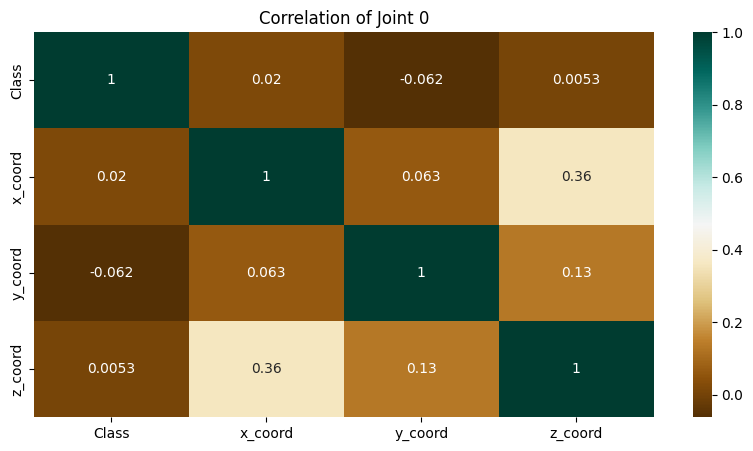

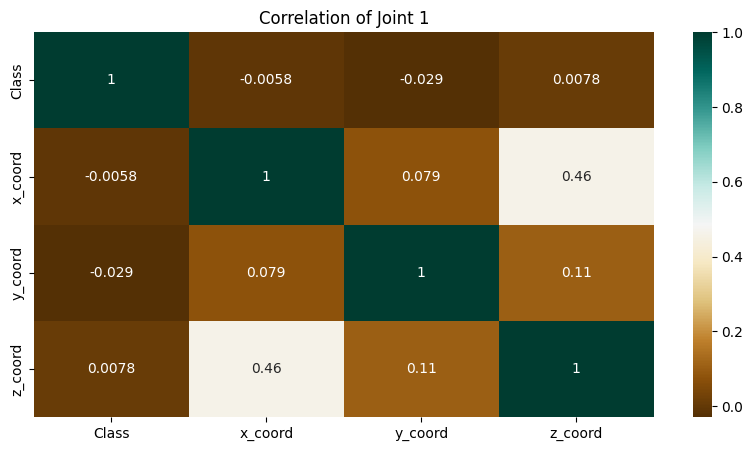

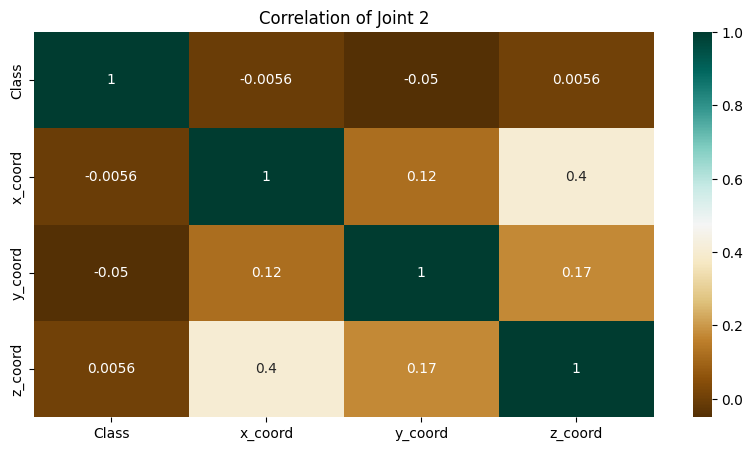

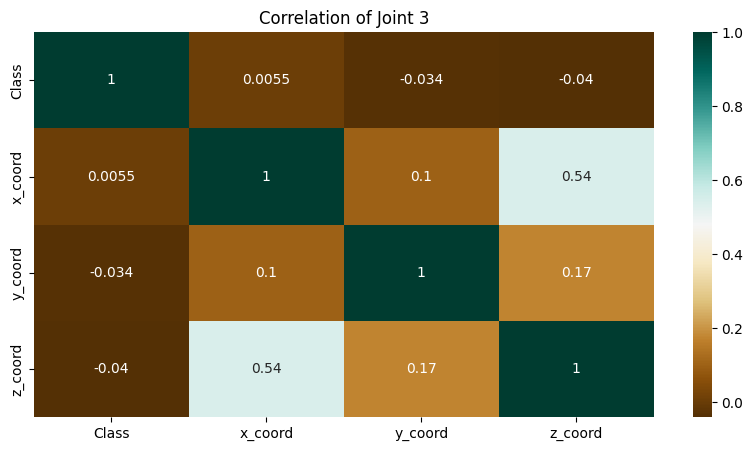

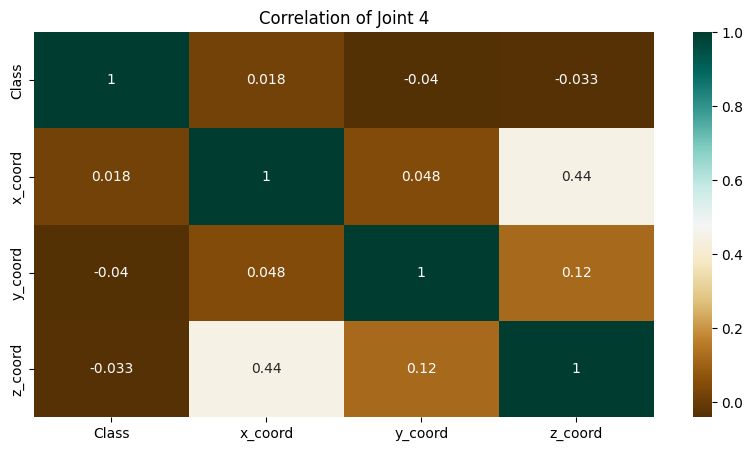

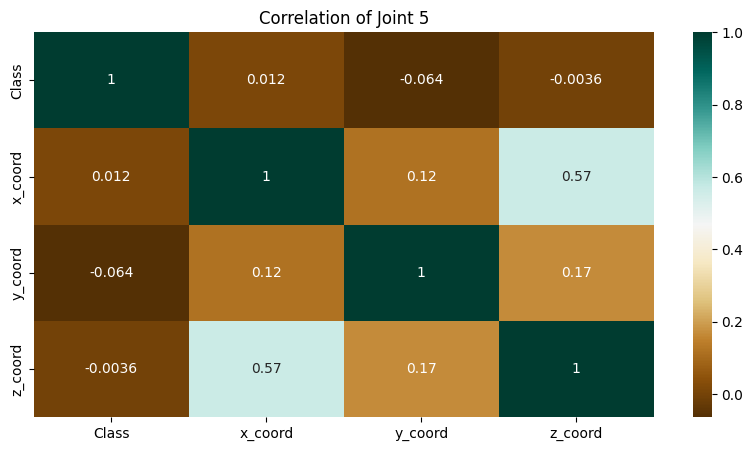

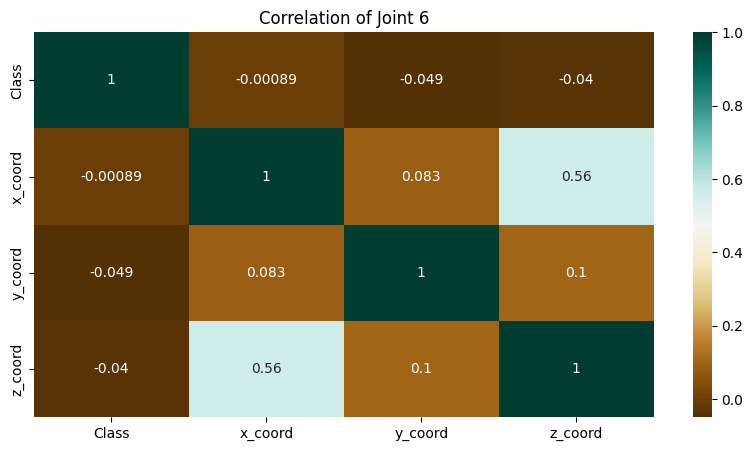

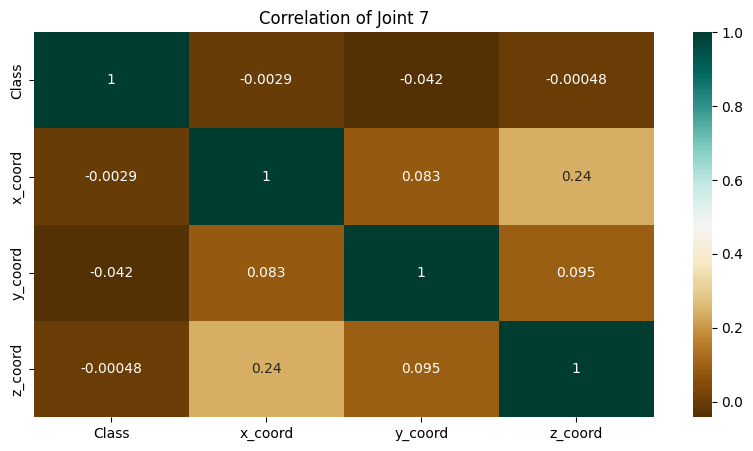

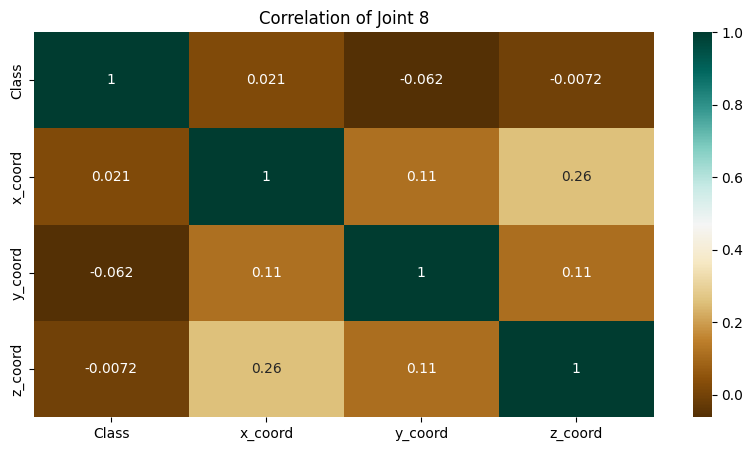

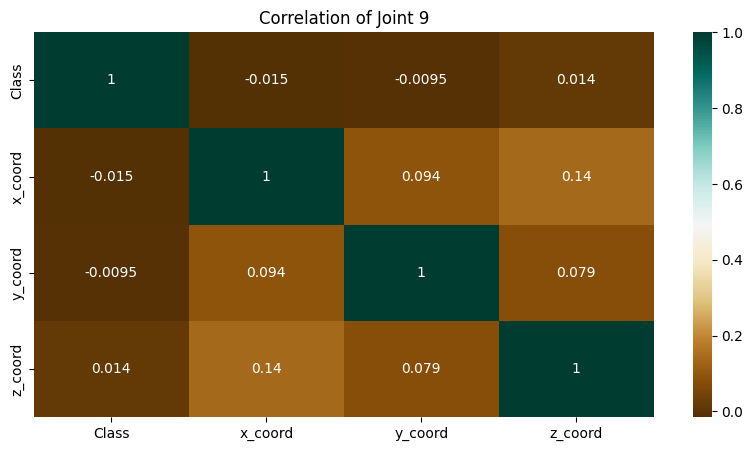

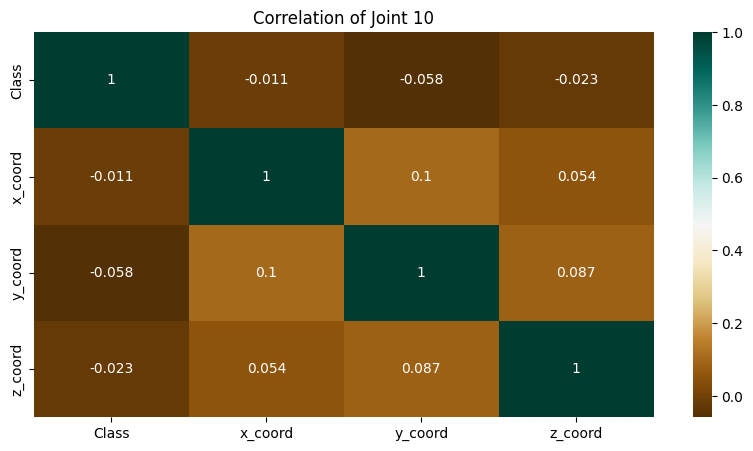

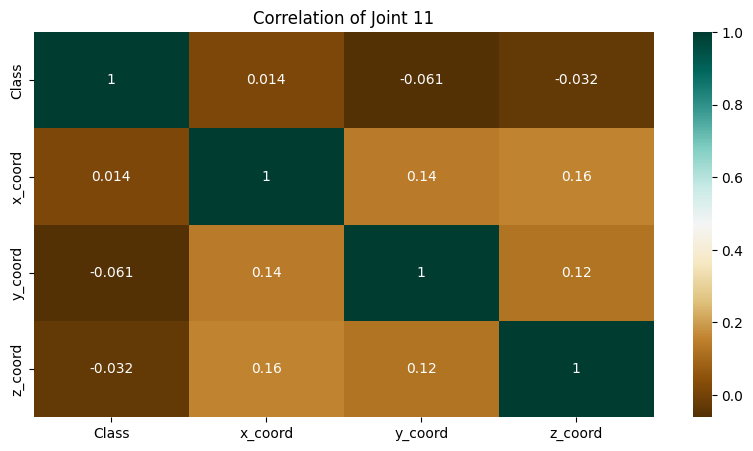

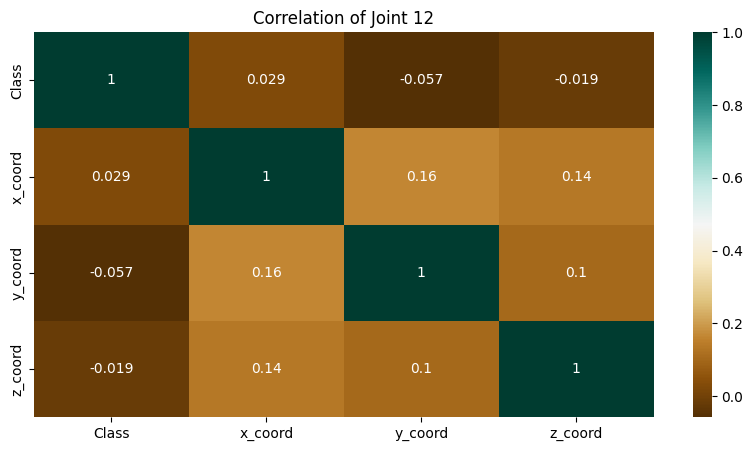

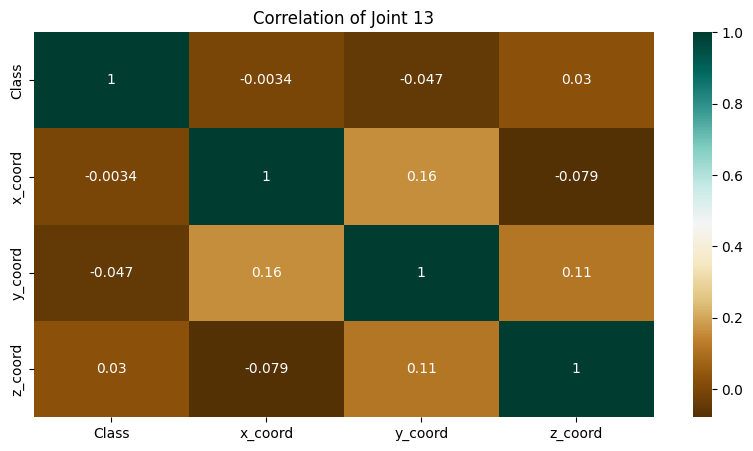

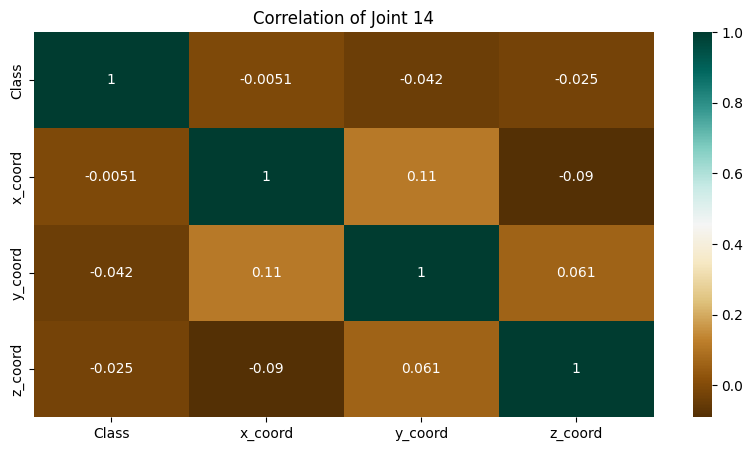

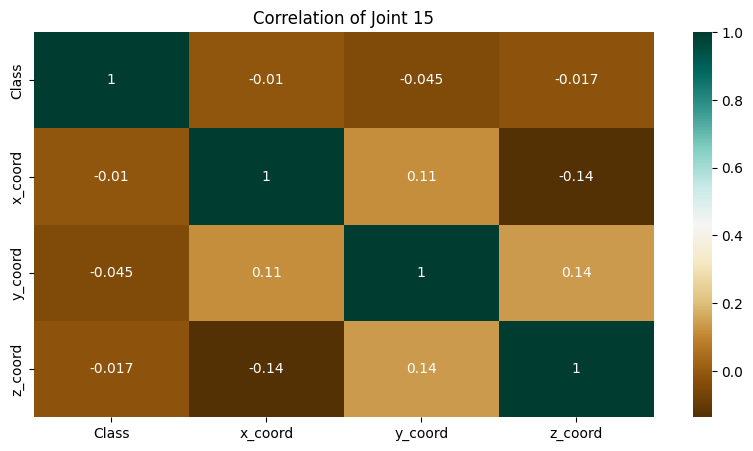

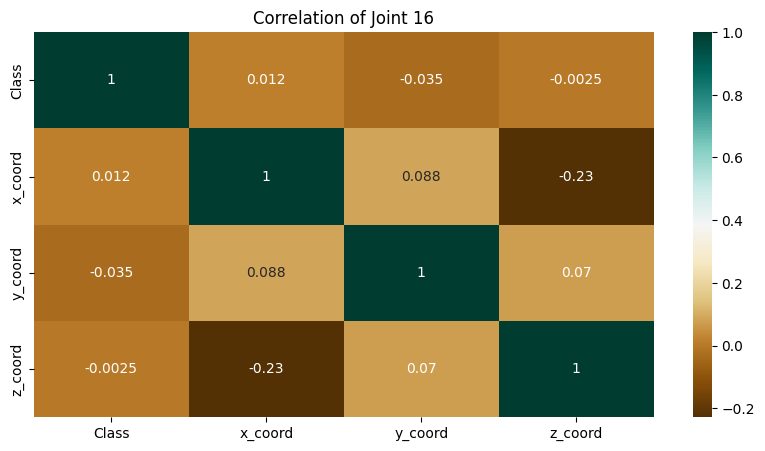

In [59]:
#Get unravelled joint data in for all 3 classes 
unravelled_regular = separate_coordinate_arrays(regular)
unravelled_limp = separate_coordinate_arrays(limp)
unravelled_stagger = separate_coordinate_arrays(stagger)

#Create adjacency matrix for charting   
combined_joints_data = create_adjacency_matrices(unravelled_regular, unravelled_limp, \
                                                 unravelled_stagger, len(unravelled_regular))

#Put classes infront
for i, joints_data in enumerate(combined_joints_data):
    combined_joints_data[i] = combined_joints_data[i][['Class', 'Instance','No_In_Sequence','x_coord','y_coord', 'z_coord']]
    combined_joints_data[i] = combined_joints_data[i].drop(['Instance', 'No_In_Sequence'], axis = 1)

plot_confusion_matrix(combined_joints_data, "Correlation of Joint ")

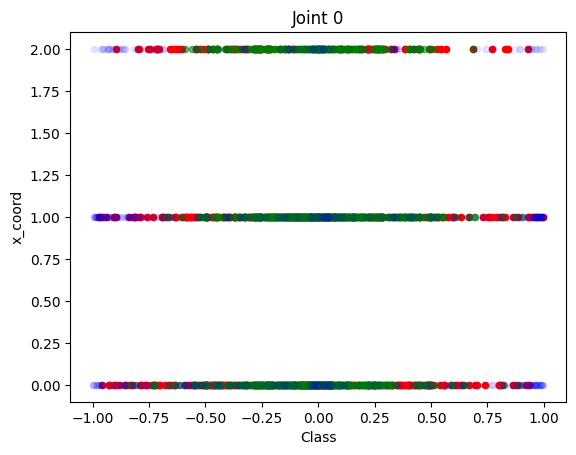

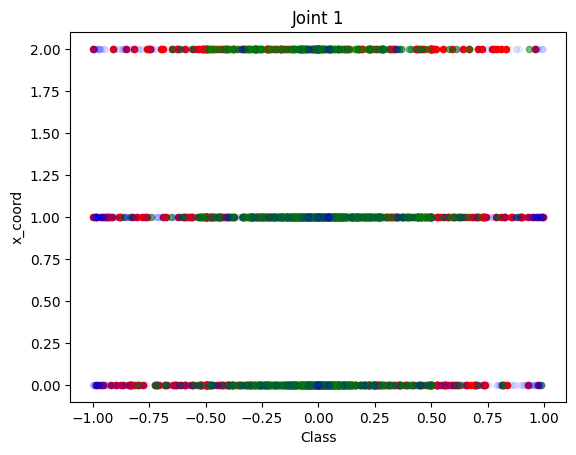

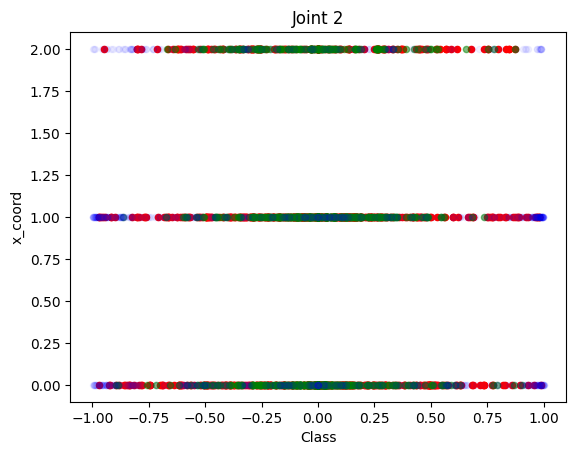

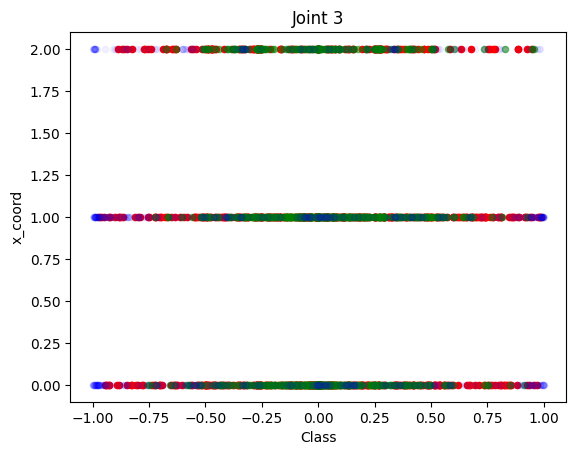

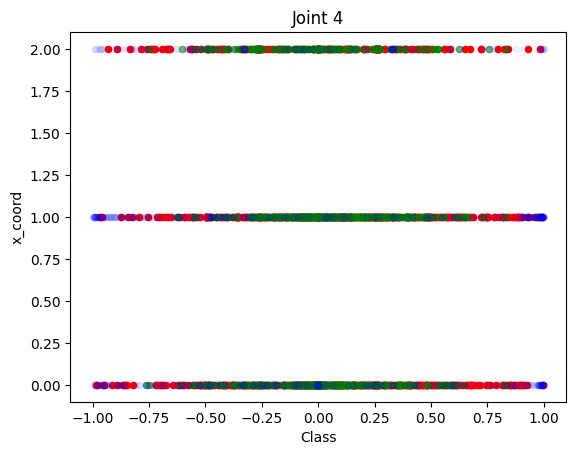

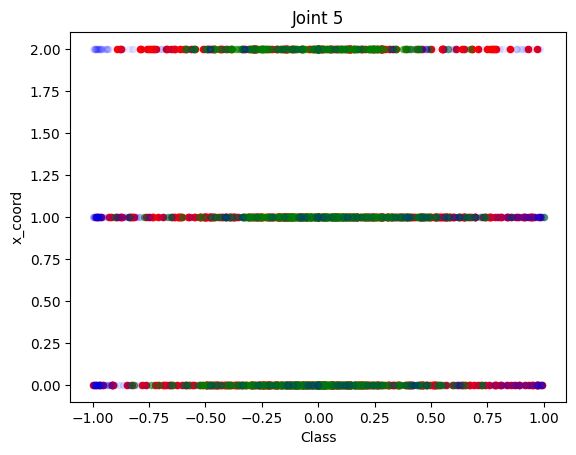

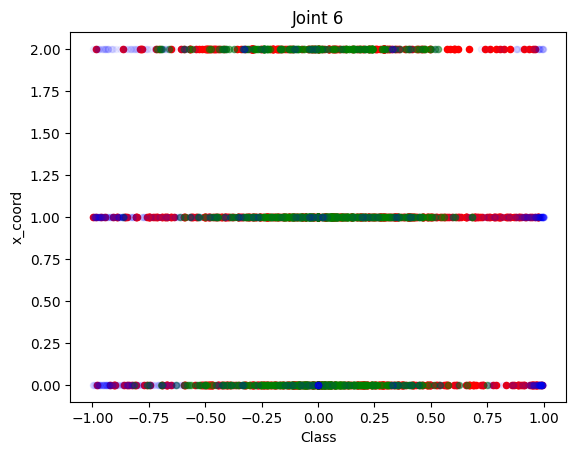

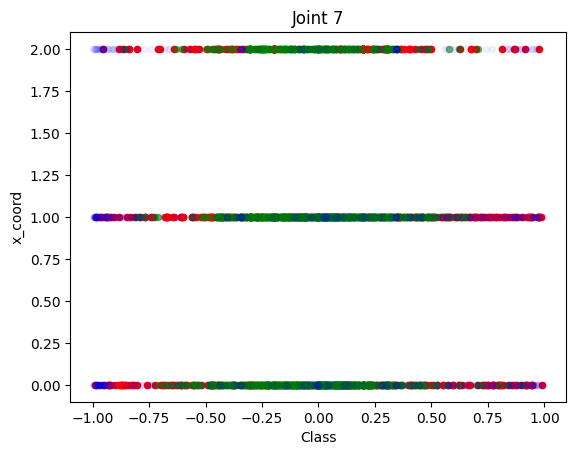

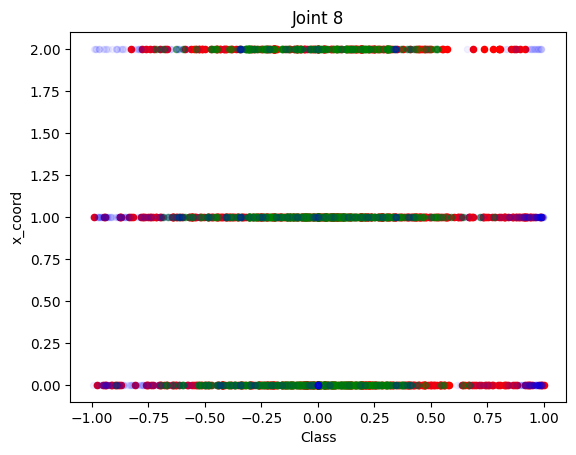

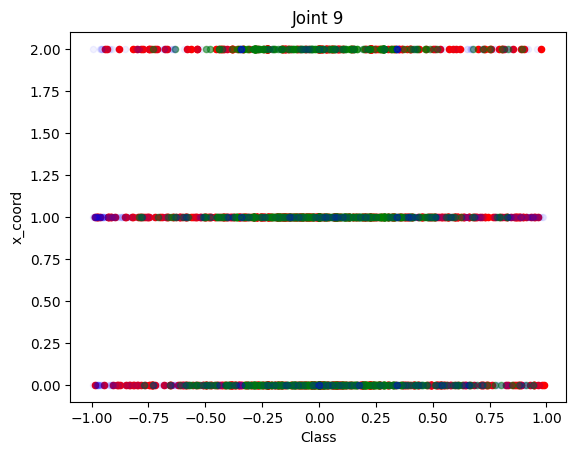

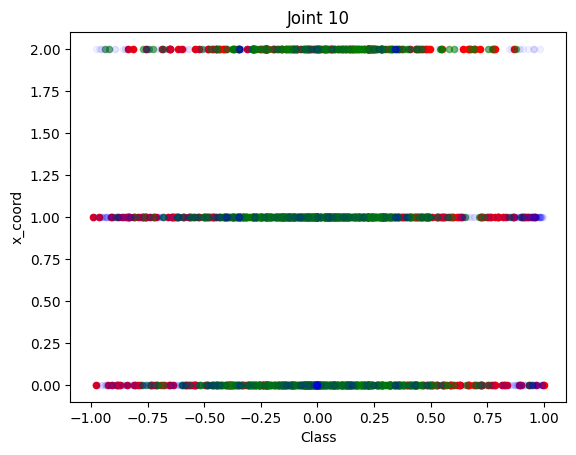

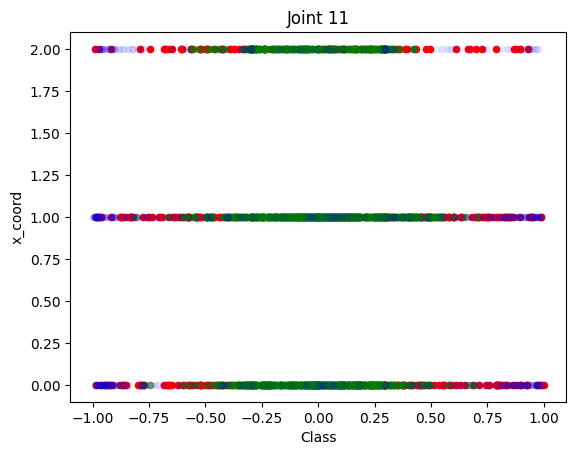

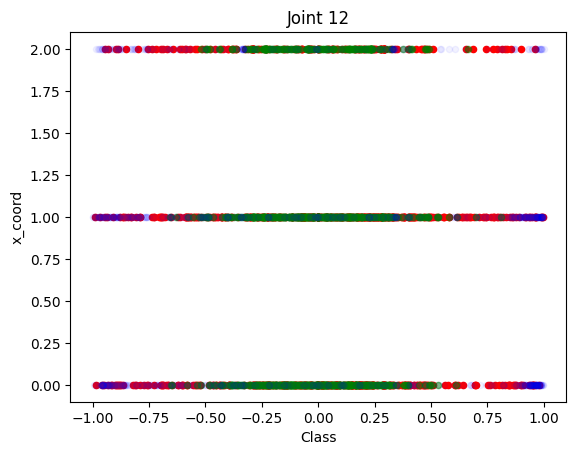

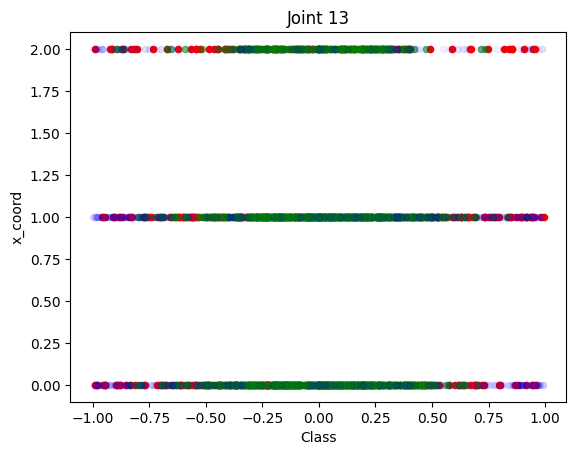

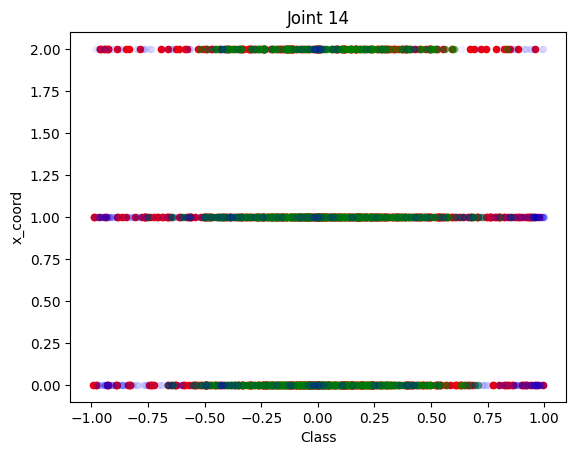

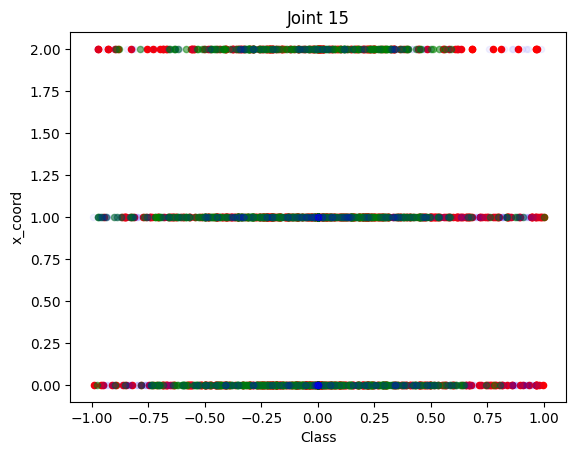

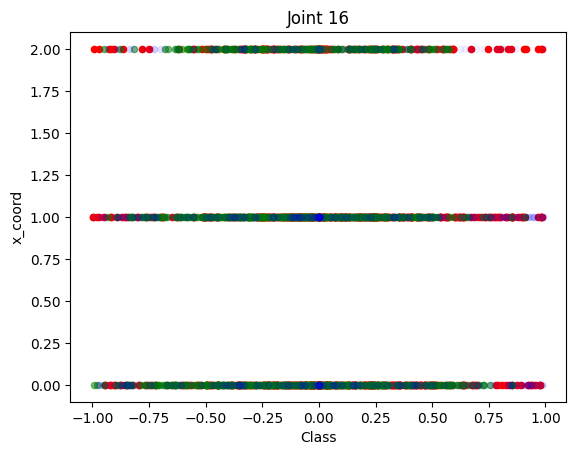

In [60]:
#Do Scatter plots
for i, joints_data in enumerate(combined_joints_data):
    plot_scatter_plot(combined_joints_data, i, "Joint ")
    

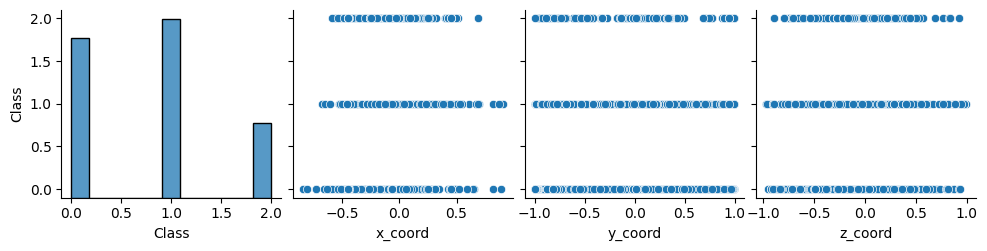

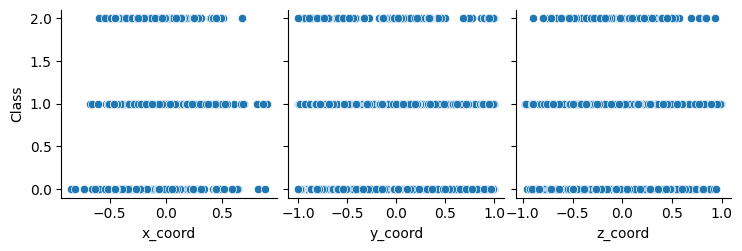

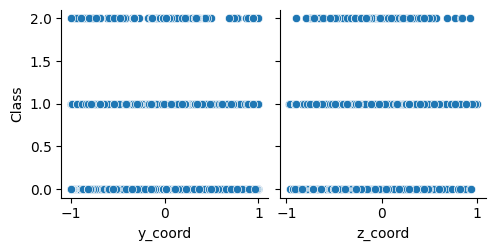

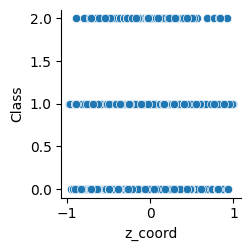

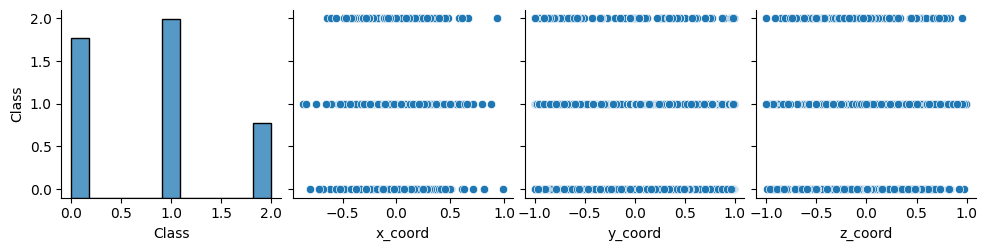

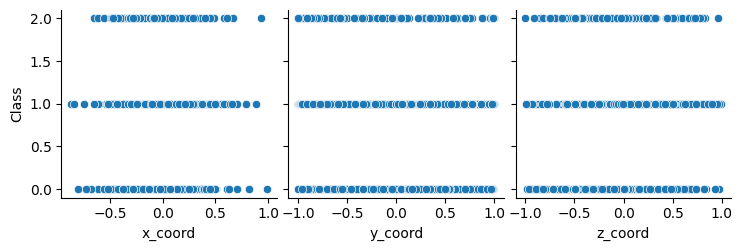

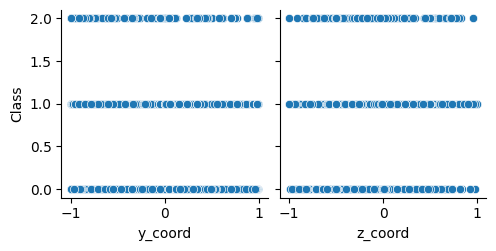

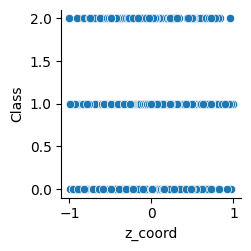

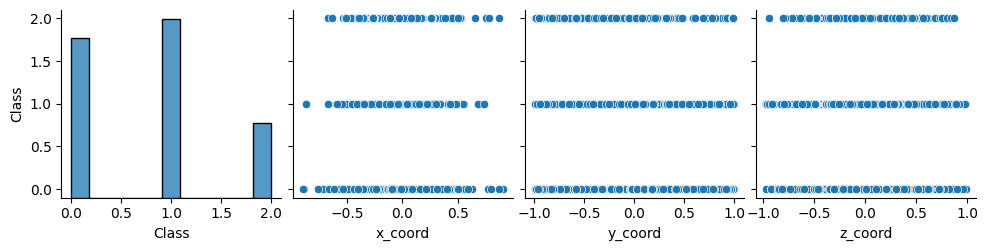

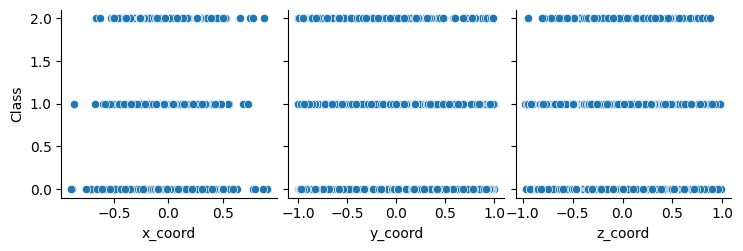

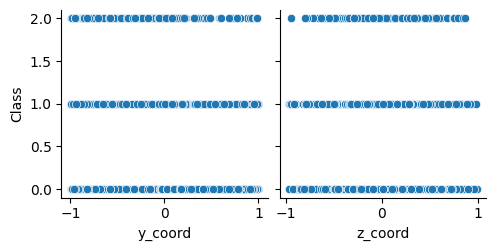

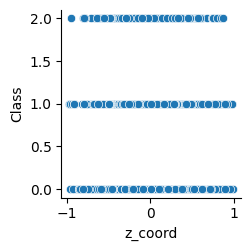

In [61]:
for i, joints_data in enumerate(combined_joints_data[0].columns):
    chart_pairplots(combined_joints_data, 0, i)
    
for i, joints_data in enumerate(combined_joints_data[1].columns):
    chart_pairplots(combined_joints_data, 1, i)
                 
for i, joints_data in enumerate(combined_joints_data[2].columns):
    chart_pairplots(combined_joints_data, 2, i)

                 

So coordinates generally will not provide any immidiate nuance as to which class it is as all it shows is which side of the frame you are on, and this will be opposites depending on which side of the frame you are starting from. What I need are more features to do with the actual gait cycle. So I need an algorithm to isolate gait cycles from the individual sequences, I need to build models of acceleration and velocity vectors of the joints instead of their raw input, I need to build a profile of each classes standard gait to remove redundant noise and finally I want to create hand crafted features such as cadence and stride length from the raw data. First though, PCA and LDA on the raw data and a basic classifier to find basic performance for comparing these ideas later down the line. I could also transform coordinates to relative positions to the centre point of the neck/chest instead of absolute to give the co-ordinates more meaning.

In [62]:
unravelled_data = unravel_joint_coords(dataset_master, save = True, get_relative = True, origin_point = 3)
unravelled_data.head()

#Cut first 86 rows then show head again
#unravelled_data.drop(index=unravelled_data.index[:86], axis=0, inplace=True)
unravelled_data.head()

,Instance,No_In_Sequence,Class,Joint_1_x,Joint_1_y,Joint_1_z,Joint_2_x,Joint_2_y,Joint_2_z,Joint_3_x,...,Joint_14_z,Joint_15_x,Joint_15_y,Joint_15_z,Joint_16_x,Joint_16_y,Joint_16_z,Joint_17_x,Joint_17_y,Joint_17_z
0,2,3,0,0.426269,0.110514,0.236816,0.000000,0.000000,0.000000,0.001577,...,0.187030,0.151775,0.132831,0.180503,0.177444,0.056084,0.193444,0.176192,0.052602,0.192262
1,2,4,0,0.317463,0.247704,0.705154,0.011047,0.014931,0.007366,0.253188,...,0.695529,0.036489,0.196238,0.775935,0.328388,0.026523,0.528990,0.407512,0.318410,0.187032
2,2,5,0,-0.116578,0.626814,0.367304,0.003275,0.020435,0.024040,0.243839,...,1.062528,0.219893,0.230963,0.473695,0.627564,0.289122,1.077243,0.655163,0.313370,0.503038
3,2,6,0,0.076878,0.969307,-0.213900,0.076878,0.032285,0.089671,0.076878,...,0.158558,0.073470,0.172897,0.690479,0.038727,0.760461,0.250822,0.265254,0.129466,0.130211
4,2,7,0,0.026526,0.944673,-0.287238,0.026526,0.007165,0.012788,0.026526,...,0.235957,0.003730,0.055551,0.122868,0.282102,0.592177,1.124554,0.251919,0.546895,0.667904


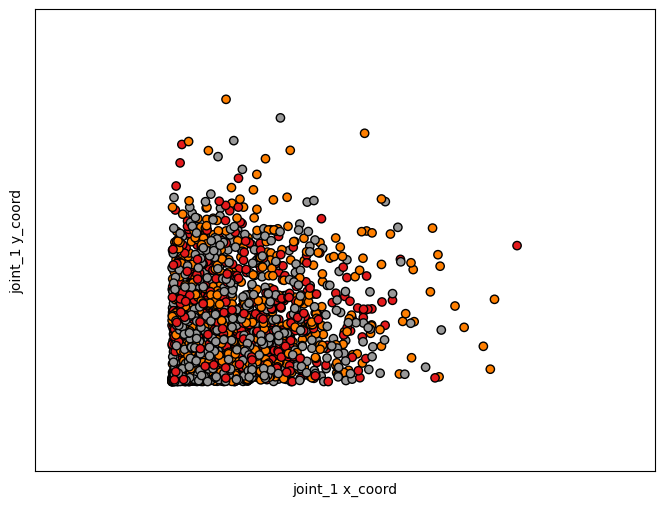

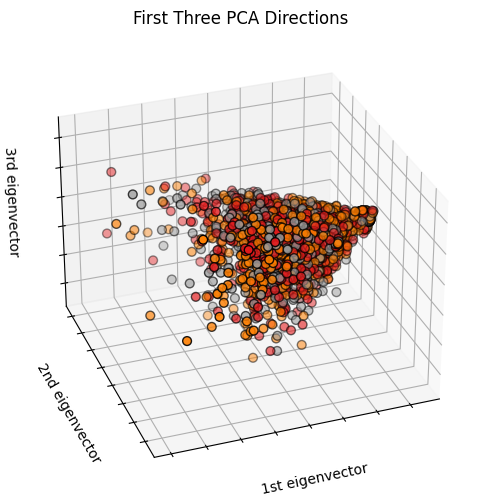

Explained Variance Ratio:  [0.26045876 0.13964691 0.08649364 0.06538448 0.05636353 0.04556994
 0.04330245 0.03920813 0.03382404 0.03033651]


In [63]:
#Create legs only dataset
#We only want joints: 2, 9, 10, 11, 12, 13, 14
legs_only = unravelled_data.drop(unravelled_data.columns[[0,1,2,3,4,5,9,10,11,12,13,14,15,16,17,18,19,20,\
                                  21,22,23,24,25,26,45,46,47,48,49,50,51,52,53]], axis = 1)

X, y = set_data(unravelled_data, legs_only, legs=True)

x_min, x_max = X.iloc[:, 3].min() - 0.5, X.iloc[:, 3].max() + 0.5
y_min, y_max = X.iloc[:, 4].min() - 0.5, X.iloc[:, 4].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points for reference
plt.scatter(X.iloc[:, 3], X.iloc[:, 4], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("joint_1 x_coord")
plt.ylabel("joint_1 y_coord")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

pca_model, pca_features = generate_PCA(X, y)

chart_PCA(pca_features)


print("Explained Variance Ratio: ", pca_model.explained_variance_ratio_)

In [64]:
X, y = set_data(unravelled_data, legs_only, legs = False)

In [65]:
#Build primitive classifier such as SVM to see how that does
SVM_classifier, y_test, y_pred = run_SVM_test(X, y)

Accuracy: 0.37006802721088433

Precision: 0.362054135363952

Recall: 0.37006802721088433


In [66]:
#Try again with PCA'd features
SVM_PCA_classifier, y_PCA_test, y__PCA_pred = run_SVM_test(pca_features, y)

Accuracy: 0.37142857142857144

Precision: 0.3623233358384003

Recall: 0.37142857142857144


In [67]:
y_test.value_counts()

1    263
0    239
2    233
Name: Class, dtype: int64

In [68]:
log_classifier, y_test, y_pred = run_LOGREG_test(X, y)

Accuracy: 0.38095238095238093

Precision: 0.3743554439963646

Recall: 0.38095238095238093


Accuracy: 0.38095238095238093

Precision: 0.3732642383388255

Recall: 0.38095238095238093


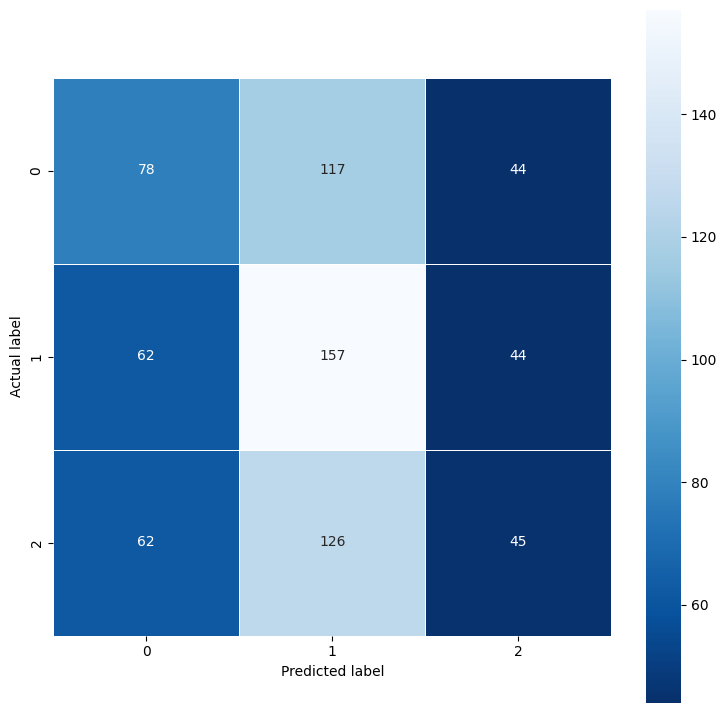

In [69]:
log_classifier, y_test, y_pred = run_LOGREG_test(pca_features, y)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_results(cm)

From the heatmap I can see that the model is just going with the safe bet of predicting limp most of the time, seems quite good as distinguishing the normal gait but not the advanced stagger gait.

It's pretty clear this raw data on it's own has little to no descriptive power because the numbers are absolute and mean nothing on their own, they need to be relative to eachother. Knowing the speed would also be useful so I need to calculate acceleration and velocity smoothed over the frames and even hand-crafted features used by professionals may come in handy too.

Time to change the data up. I have 3 ideas:

Get velocity and accelerations from joints, also direction vector
    smooth these velocities and accelerations across time (need absolute for this)
    
Absolute values used for calculation: (abs values take longer to process)
        
        SVM   : 45.05% full body data, 47.03% legs only data, 41.4% PCA'd data 
        LOGREG: 43.8% full body data, 45.3% legs only data, 43.07% PCA'd data
        
Relative values: (Nose is just barely better on normal, PCA better average)
    
    Nose_origin (1)
        SVM   : 50.0% full body data, 47.4% legs only data, 45.3% PCA'd data 
        LOGREG: 51.5% full body data, 48.5% legs only data, 47.7% PCA'd data 

    Nose origin (with nose set to 0,0,0) (PCA here is best performing)
        SVM   : 49.3% full body data, 47.4% legs only data, 49.9% PCA'd data 
        LOGREG: 50.5% full body data, 48.5% legs only data, 50.2% PCA'd data 
        
    Chest_origin (2)
         SVM   : 50.9% full body data, % legs only data, 48.5% PCA'd data 
        LOGREG: 49.4% full body data, % legs only data, 49.7% PCA'd data
        
    Chest origin (with chest set to 0,0,0) (PCA here is best performing)
        SVM   : 47.4% full body data, 47.4% legs only data, 50.0% PCA'd data 
        LOGREG: 46.5% full body data, 48.5% legs only data, 50.2% PCA'd data 


Velocities : (Nose origin, origin not set to 0)

        SVM   : 45.05% full body data, 47.03% legs only data, 41.4% PCA'd data 
        LOGREG: 43.8% full body data, 45.3% legs only data, 43.07% PCA'd data
        

Velocity dataset:
        
        (including empties): 35% SVM, 36% LOGREG (totally random)
        (no empties): 37% SVM, 36% LOGREG (more or less random
        
     

PCA when everything set to 0 is quite good, but origin included without PCA is better

Nose Origin is best

Full body is better than just legs, except when absolute values

relative values way better than absolute





extract hand-crafted features (select the most important, consult research proposal to get em)



In [31]:
unravelled_data.head()

,Instance,No_In_Sequence,Class,Joint_1_x,Joint_1_y,Joint_1_z,Joint_2_x,Joint_2_y,Joint_2_z,Joint_3_x,...,Joint_14_z,Joint_15_x,Joint_15_y,Joint_15_z,Joint_16_x,Joint_16_y,Joint_16_z,Joint_17_x,Joint_17_y,Joint_17_z
0,2,4,0,27,7,15.0,0,0,0.0,1,...,189.0,96,17,172.0,69,14,151.0,68,15,148.0
1,2,5,0,4,36,114.0,3,4,1.0,4,...,21.0,147,20,99.0,192,27,12.0,187,40,67.0
2,2,6,0,3,99,101.0,2,5,5.0,3,...,17.0,154,2,10.0,195,33,7.0,205,15,20.0
3,2,7,0,6,116,97.0,5,5,0.0,6,...,18.0,155,4,17.0,190,49,10.0,209,8,21.0
4,2,8,0,4,132,91.0,3,4,4.0,4,...,27.0,155,12,18.0,180,44,39.0,211,8,28.0


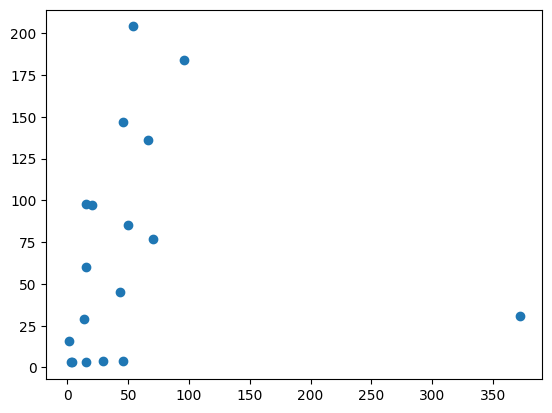

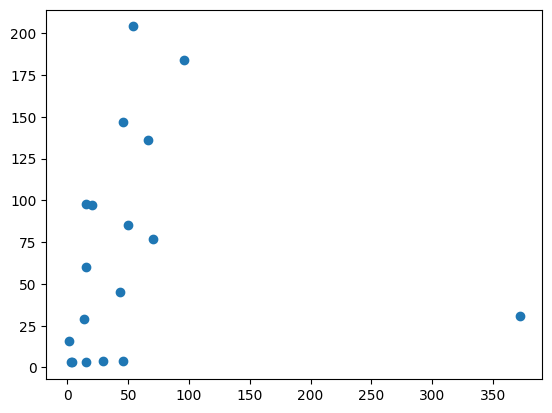

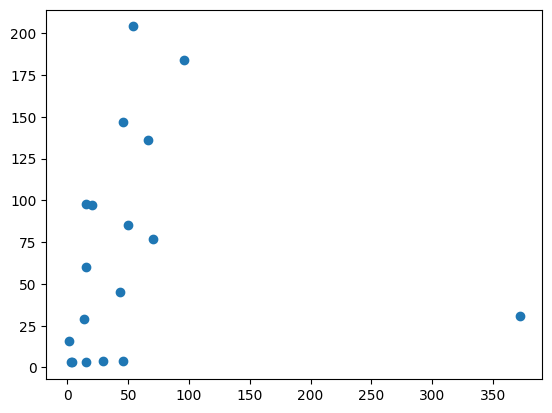

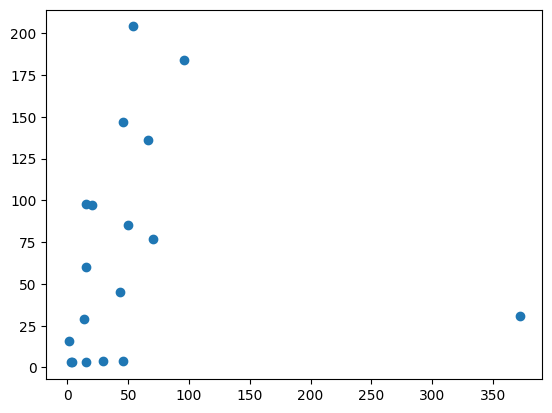

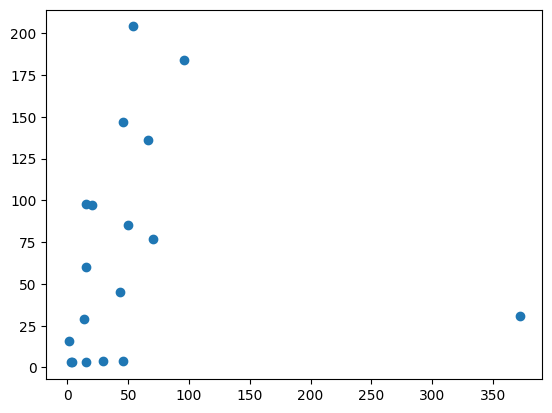

In [22]:
for i in range(5):
    plot_skeleton(unravelled_data.iloc[4])

In [24]:
# load in first entire instance of raw images
def load_images_from_folder(folder):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

images = load_images_from_folder("./Images/Instance_0.0")
        
#for im in images:
#    cv2.imshow('image',im)
#    # Waits for a keystroke
#    cv2.waitKey(0)  
    

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2190 samples in 0.001s...
[t-SNE] Computed neighbors for 2190 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2190
[t-SNE] Computed conditional probabilities for sample 2000 / 2190
[t-SNE] Computed conditional probabilities for sample 2190 / 2190
[t-SNE] Mean sigma: 39.508928
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.560631
[t-SNE] KL divergence after 1000 iterations: 0.709128


[Text(0.5, 1.0, 'T-SNE projection')]

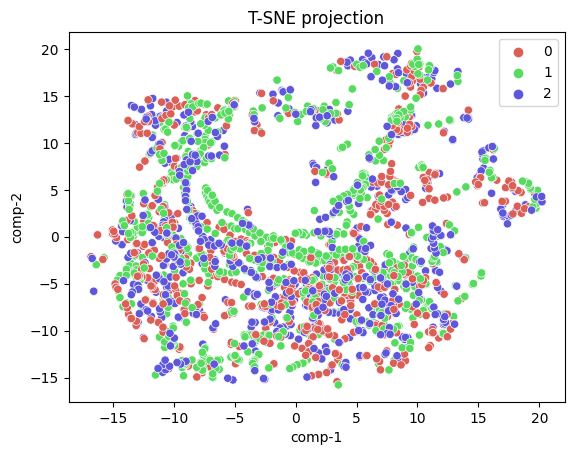

In [27]:
#X = unravelled_data.drop(['Class', 'Instance', 'No_In_Sequence'], axis = 1)
#X = legs_only
#y = unravelled_data['Class']
X, y = set_data(unravelled_data, legs_only, legs=False)

tsne = TSNE(n_components=3, verbose=1, random_state=123)
z = tsne.fit_transform(X) 

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="T-SNE projection") 

In [33]:
#run feature selected elements to classifier
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=15)
sfs.fit(X, y)

sfs.get_support()

new_X = sfs.transform(X)

In [34]:
log_classifier, y_test, y_pred = run_LOGREG_test(new_X, y)

Accuracy: 0.4977168949771689

Precision: 0.4886655568519842

Recall: 0.4977168949771689


C:\Users\chris\.conda\envs\procenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
SVM_classifier, y_test, y_pred = run_SVM_test(new_X, y)

Accuracy: 0.4779299847792998

Precision: 0.46327808483945815

Recall: 0.4779299847792998


In [ ]:
#Load in images and display via matplotlib

#Draw normal joints on top

#Draw velocity joints on top

#Draw them as arrows

#Done